# Nengo Tests 1

https://www.nengo.ai/nengo/getting_started.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline
import os
import numpy as np
import pandas as pd
import datetime as dt
print(dt.datetime.now())

Populating the interactive namespace from numpy and matplotlib
2018-12-26 03:37:58.956612


In [3]:
import nengo
from nengo.dists import Uniform
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ensemble import sorted_neurons

## A single LIF neuron

In [4]:
model = nengo.Network(label='A Single LIF Neuron')

In [5]:
with model:
    neuron = nengo.Ensemble(
        1,                               # 1 neuron
        dimensions=1,                    # Represent a scalar
        intercepts=Uniform(-0.5, -0.5),  # Set intercept to 0.5
        max_rates=Uniform(100, 100),     # Set the maximum firing rate of the neuron to 100hz
        encoders=[[1]]                   # Sets the neurons firing rate to increase for positive input
    )

In [6]:
# Create an input node generating a cosine wave
with model:
    cos_input = nengo.Node(lambda t: np.cos(8 * t))

In [7]:
# Connect the input signal to the neuron
with model:
    nengo.Connection(cos_input, neuron)

In [8]:
# Anything that is probed will collect the data it produces over time, allowing us to analyze and visualize it later
with model:
    cos_probe = nengo.Probe(cos_input)                # The original input
    spikes = nengo.Probe(neuron.neurons)              # The raw spikes from the neuron
    voltage = nengo.Probe(neuron.neurons, 'voltage')  # Subthreshold soma voltage of the neuron
    filtered = nengo.Probe(neuron, synapse=0.01)      # Spikes filtered by a 10ms post-synaptic filter

In [9]:
# Create the simulator and run the model
with nengo.Simulator(model) as sim:
    sim.run(1)  # Run for 1 second
    eval_points, activities = tuning_curves(neuron, sim)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

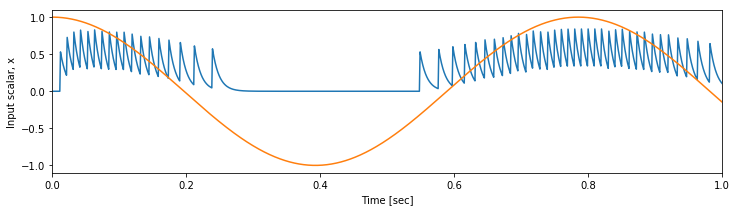

In [10]:
# Plot the decoded output of the ensemble
plt.figure(figsize=(12, 3))
plt.plot(sim.trange(), sim.data[filtered])
plt.plot(sim.trange(), sim.data[cos_probe])
plt.xlabel("Time [sec]")
plt.ylabel("Input scalar, x")
plt.xlim(0, 1);

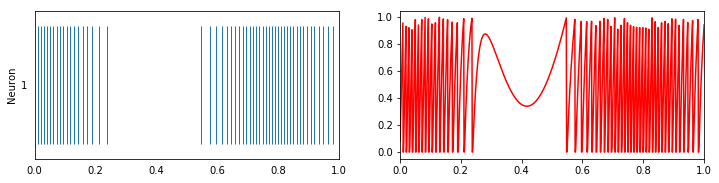

In [11]:
# Plot the spiking output of the ensemble
plt.figure(figsize=(12, 6))
plt.subplot(221)
rasterplot(sim.trange(), sim.data[spikes])
plt.ylabel("Neuron")
plt.xlim(0, 1)

# Plot the soma voltages of the neurons
plt.subplot(222)
plt.plot(sim.trange(), sim.data[voltage][:, 0], 'r')
plt.xlim(0, 1);

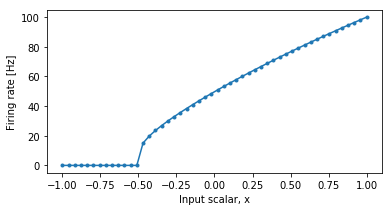

In [12]:
plt.figure(figsize=(6, 3))
plt.plot(eval_points, activities, marker='.')
plt.ylabel("Firing rate [Hz]")
plt.xlabel("Input scalar, x");

## Multiple LIF neurons

In [13]:
model = nengo.Network(label='Many LIF Neurons')

In [14]:
with model:
    # Our ensemble consists of 12 leaky integrate-and-fire neurons,
    # representing a one-dimensional signal
    A = nengo.Ensemble(12, dimensions=1)

In [15]:
# Create an input node generating a sine wave
with model:
    sin_input = nengo.Node(lambda t: np.sin(8 * t))

In [16]:
# Connect the input to the population
with model:
    nengo.Connection(sin_input, A, synapse=0.01)  # 10ms filter

In [17]:
with model:
    sin_probe = nengo.Probe(sin_input)       # The original input
    A_probe = nengo.Probe(A, synapse=0.01)   # 10ms filter
    A_spikes = nengo.Probe(A.neurons)        # Collect the spikes

In [18]:
# Create our simulator and run the model
with nengo.Simulator(model) as sim:
    sim.run(1)
    eval_points, activities = tuning_curves(A, sim)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

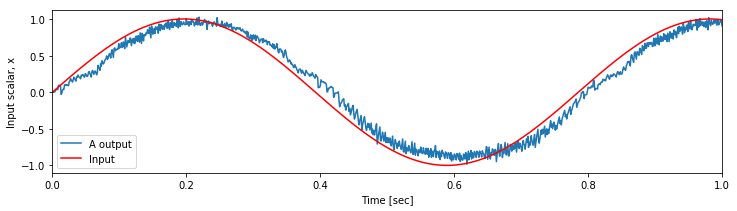

In [19]:
# Plot the decoded output of the ensemble
plt.figure(figsize=(12, 3))
plt.plot(sim.trange(), sim.data[A_probe], label="A output")
plt.plot(sim.trange(), sim.data[sin_probe], 'r', label="Input")
plt.xlim(0, 1)
plt.xlabel("Time [sec]")
plt.ylabel("Input scalar, x")
plt.legend();

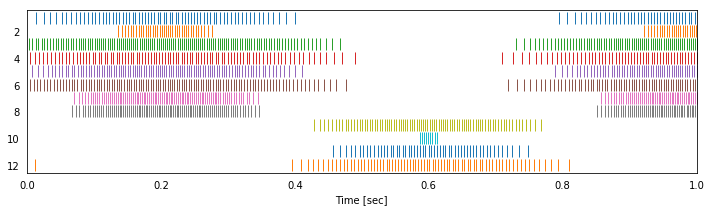

In [20]:
# Plot the spiking output of the ensemble
indices = sorted_neurons(A, sim, iterations=250)
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[A_spikes][:, indices])
plt.xlabel("Time [sec]");
plt.xlim(0, 1);

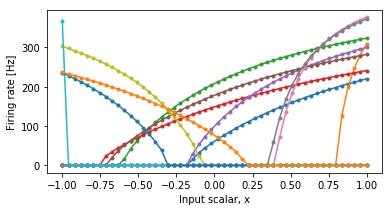

In [21]:
plt.figure(figsize=(6, 3))
plt.plot(eval_points, activities[:, indices], marker='.')
plt.ylabel("Firing rate [Hz]")
plt.xlabel("Input scalar, x");

## Combining 2 1D inputs into a 2D representation

In [22]:
model = nengo.Network(label='Combining Inputs')

In [23]:
with model:
    # Our input ensembles consist of 100 leaky integrate-and-fire neurons,
    # representing a one-dimensional signal
    A = nengo.Ensemble(10, dimensions=1)
    B = nengo.Ensemble(10, dimensions=1)

    # The output ensemble consists of 200 leaky integrate-and-fire neurons,
    # representing a two-dimensional signal
    output = nengo.Ensemble(20, dimensions=2, label='2D Population')

In [24]:
# Create input nodes generating the sine and cosine
with model:
    sin_input = nengo.Node(output=np.sin)
    cos_input = nengo.Node(output=np.cos)

In [25]:
with model:
    # Connect inputs to A and B
    nengo.Connection(sin_input, A)
    nengo.Connection(cos_input, B)

    # The square brackets define which dimension the input will project to
    nengo.Connection(A, output[1])
    nengo.Connection(B, output[0])

In [26]:
with model:
    sin_probe = nengo.Probe(sin_input)
    cos_probe = nengo.Probe(cos_input)
    A_probe = nengo.Probe(A, synapse=0.01)         # 10ms filter
    B_probe = nengo.Probe(B, synapse=0.01)         # 10ms filter
    out_probe = nengo.Probe(output, synapse=0.01)  # 10ms filter

In [27]:
# Create our simulator and run the model
with nengo.Simulator(model) as sim:
    sim.run(8)
    eval_points_A, activities_A = tuning_curves(A, sim)
    eval_points_B, activities_B = tuning_curves(B, sim)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

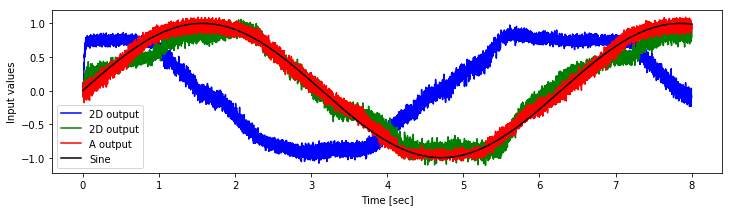

In [28]:
# Plot the decoded output of the ensemble
plt.figure(figsize=(12, 3))
plt.plot(sim.trange(), sim.data[out_probe][:, 0], 'b', label="2D output")
plt.plot(sim.trange(), sim.data[out_probe][:, 1], 'g', label="2D output")
plt.plot(sim.trange(), sim.data[A_probe], 'r', label="A output")
plt.plot(sim.trange(), sim.data[sin_probe], 'k', label="Sine")
plt.xlabel("Time [sec]")
plt.ylabel("Input values")
plt.legend();

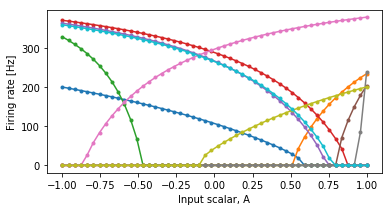

In [29]:
plt.figure(figsize=(6, 3))
plt.plot(eval_points_A, activities_A, marker='.')
plt.ylabel("Firing rate [Hz]")
plt.xlabel("Input scalar, A");

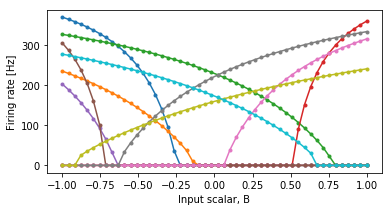

In [30]:
plt.figure(figsize=(6, 3))
plt.plot(eval_points_B, activities_B, marker='.')
plt.ylabel("Firing rate [Hz]")
plt.xlabel("Input scalar, B");

## Addition of 2 inputs into an ensemble

In [31]:
model = nengo.Network(label='Addition of Inputs')

In [32]:
with model:
    # Create 3 ensembles each containing 100 leaky integrate-and-fire neurons
    A = nengo.Ensemble(100, dimensions=1)
    B = nengo.Ensemble(100, dimensions=1)
    C = nengo.Ensemble(100, dimensions=1)

In [33]:
with model:
    # Create input nodes representing constant values
    input_a = nengo.Node(output=0.5)
    input_b = nengo.Node(output=0.3)

    # Connect the input nodes to the appropriate ensembles
    nengo.Connection(input_a, A)
    nengo.Connection(input_b, B)

    # Connect input ensembles A and B to output ensemble C
    nengo.Connection(A, C)
    nengo.Connection(B, C)

In [34]:
with model:
    input_a_probe = nengo.Probe(input_a)
    input_b_probe = nengo.Probe(input_b)
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)
    C_probe = nengo.Probe(C, synapse=0.01)

In [35]:
# Create our simulator and run the model
with nengo.Simulator(model) as sim:
    sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

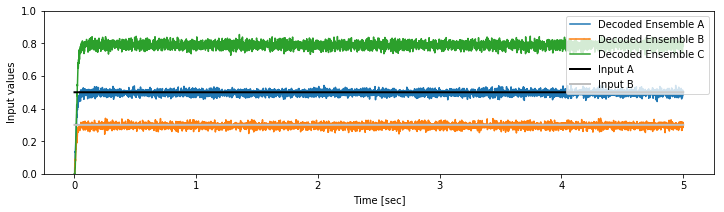

In [36]:
# Plot the input signals and decoded ensemble values
t = sim.trange()
plt.figure(figsize=(12, 3))
plt.plot(
    sim.trange(),
    sim.data[A_probe],
    label="Decoded Ensemble A")
plt.plot(
    sim.trange(),
    sim.data[B_probe],
    label="Decoded Ensemble B")
plt.plot(
    sim.trange(),
    sim.data[C_probe],
    label="Decoded Ensemble C")
plt.plot(
    sim.trange(),
    sim.data[input_a_probe],
    label="Input A",
    color='k',
    linewidth=2.0)
plt.plot(
    sim.trange(),
    sim.data[input_b_probe],
    label="Input B",
    color='0.75',
    linewidth=2.0)
plt.legend(loc=1)
plt.ylim(0, 1)
plt.xlabel('Time [sec]')
plt.ylabel("Input values");